# Classification dans un contexte déséquilibré : Détection de fraude par chèque

## 1. Introduction du sujet et présentation des données d'études

### 1.1 La fraude par chèque

La fraude par chèque fait référence à tout moyen visant à obtenir de l'argent illégalement à l'aide de chèques papier ou numériques. 

Cela peut inclure une personne écrivant un chèque sans provision sur son propre compte, falsifiant un chèque au nom de quelqu'un d'autre ou élaborant un chèque complètement faux. 

Il existe de nombreuses autres moyens de fraude par chèque (Check Kiting, Chèque flottant, Vol de chèque, Altération chimique, Fraude par mandat-poste ...)

### 1.2 Données d'études

Notre étude va porter sur la détection de fraude par chèque dans un contexte déséquilibré. En effet nous disposons d'un jeu de données contenant très peu de transactions frauduleuses par rapport à la taille de notre échantillon d'étude.

Ces transactions sont issues d'une enseigne de la grande distribution ainsi que de certains organismes bancaires (FNCI et Banque de France). Elles ont été effectuées par chèque dans un magasin de l'enseigne quelque part en France durant l'année 2017, du 01/02 au 30/11 (soit au total 10 mois de transactions). 

Le jeu de donnée est composé de 4 646 773 transactions dont seulement 29 995 frauduleuses, soit 0.64% du total des transactions.  
Il comporte 23 variables sont certaines sont issues du feature engineering : 

* **ZIBZIN** : identiﬁant relatif à la personne, i.e. il s’agit de son identiﬁant bancaire (relatif au chéquier en cours d’utilisation)  
* **IDAvisAutorisAtionCheque** : identiﬁant de la transaction en cours

* **Montant** : montant de la transaction

* **DateTransaction** : date de la transaction

* **CodeDecision** : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Vous n’en rencontrerez pas dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique cet un mauvais payer (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée  

* **VériﬁanceCPT1** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours du même jour
* **VériﬁanceCPT2** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours des trois derniers jours
* **VériﬁanceCPT3** : nombre de transactions eﬀectuées par le même identiﬁant bancaire au cours des sept derniers jours

* **D2CB** : durée de connaissance du client (par son identiﬁant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans

* **ScoringFP1** : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
* **ScoringFP2** : score d’anormalité du panier relatif à une deuxième famille de produits (ex : électroniques)
* **ScoringFP3** : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)

* **TauxImpNb_RB** : taux impayés enregistrés selon la région où a lieu la transaction
* **TauxImpNB_CPM** : taux d’impayés relatif au magasin où a lieu la transaction

* **EcartNumCheq** : diﬀérence entre les numéros de chèques

* **NbrMagasin3J** : nombre de magasins diﬀérents fréquentés les 3 derniers jours

* **DiﬀDateTr1** : écart (en jours) à la précédente transaction
* **DiﬀDateTr2** : écart (en jours) à l’avant dernière transaction
* **DiﬀDateTr3** : écart (en jours) à l’antépénultième transaction

* **CA3TRetMtt** : montant des dernières transactions + montant de la transaction en cours
* **CA3TR** : montant des trois dernières transactions
* **Heure** : heure de la transaction

* <span style="color:red"> **FlagImpaye** </span> : variable cible à prédire. Acception (0) ou refus de la transaction (1) car considérée comme frauduleuse.

## 2. Chargement des données + import des librairies

Le jeu de données étant volumineux (970 Mo) nous avons choisit d'utiliser la librairie **Dask** afin de faire des calculs parallèles. 

In [1]:
import pandas as pd
import numpy as np
import sys
import dask.dataframe as ddf
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from dask import delayed
from collections import Counter

from imblearn.over_sampling import ADASYN
import pickle

In [2]:
#Connexion à Google drive (uniquement à exécuter depuis Google colab)

#import os
#from google.colab import drive
#MOUNTPOINT = '/content/drive'
#DATADIR = os.path.join(MOUNTPOINT,'MyDrive','Colab Notebooks/Projet Fouille de données')
#drive.mount(MOUNTPOINT)
#os.chdir(DATADIR)

In [3]:
#!pip install "dask[complete]"

data = ddf.read_csv("guillaume.txt", sep=';',dtype={
       'CA3TRetMtt': 'float64',
       'CA3TR': 'float64',
       'CodeDecision': 'category',
       'D2CB': 'int64',
       'DiffDateTr1': 'float64',
       'DiffDateTr2': 'float64',
       'DiffDateTr3': 'float64',
       'EcartNumCheq': 'int64',
       'FlagImpaye': 'int64',
       'Heure': 'int64',
       'Montant': 'float64',
       'NbrMagasin3J': 'int64',
       'ScoringFP1': 'float64',
       'ScoringFP2': 'float64',
       'ScoringFP3': 'float64',
       'TauxImpNB_CPM': 'float64',
       'TauxImpNb_RB': 'float64',
       'VerifianceCPT1': 'int64',
       'VerifianceCPT2': 'int64',
       'VerifianceCPT3': 'int64'}, header=0, assume_missing=True, parse_dates=['DateTransaction'],decimal=",",blocksize=300*1024*1024)

In [4]:
data = pd.read_csv("guillaume.txt", sep=';',dtype={
       'CA3TRetMtt': 'float64',
       'CA3TR': 'float64',
       'CodeDecision': 'category',
       'D2CB': 'int64',
       'DiffDateTr1': 'float64',
       'DiffDateTr2': 'float64',
       'DiffDateTr3': 'float64',
       'EcartNumCheq': 'int64',
       'FlagImpaye': 'int64',
       'Heure': 'int64',
       'Montant': 'float64',
       'NbrMagasin3J': 'int64',
       'ScoringFP1': 'float64',
       'ScoringFP2': 'float64',
       'ScoringFP3': 'float64',
       'TauxImpNB_CPM': 'float64',
       'TauxImpNb_RB': 'float64',
       'VerifianceCPT1': 'int64',
       'VerifianceCPT2': 'int64',
       'VerifianceCPT3': 'int64'}, header=0, parse_dates=['DateTransaction'],decimal=",")

## 3. Exploration des données

In [25]:
data.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [26]:
data.dtypes

ZIBZIN                              object
IDAvisAutorisationCheque             int64
FlagImpaye                           int64
Montant                            float64
DateTransaction             datetime64[ns]
CodeDecision                      category
VerifianceCPT1                       int64
VerifianceCPT2                       int64
VerifianceCPT3                       int64
D2CB                                 int64
ScoringFP1                         float64
ScoringFP2                         float64
ScoringFP3                         float64
TauxImpNb_RB                       float64
TauxImpNB_CPM                      float64
EcartNumCheq                         int64
NbrMagasin3J                         int64
DiffDateTr1                        float64
DiffDateTr2                        float64
DiffDateTr3                        float64
CA3TRetMtt                         float64
CA3TR                              float64
Heure                                int64
dtype: obje

In [28]:
%%time

# Calcul du nombre de lignes
nrows = data.index.size
print(nrows)

4646773
Wall time: 1 ms


Nombre de lignes : 4 646 773

#### Vérifications de la présence de valeurs nulles

In [29]:
data.isnull().sum()

ZIBZIN                      0
IDAvisAutorisationCheque    0
FlagImpaye                  0
Montant                     0
DateTransaction             0
CodeDecision                0
VerifianceCPT1              0
VerifianceCPT2              0
VerifianceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TauxImpNb_RB                0
TauxImpNB_CPM               0
EcartNumCheq                0
NbrMagasin3J                0
DiffDateTr1                 0
DiffDateTr2                 0
DiffDateTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
dtype: int64

-> Pas de valeurs nulles

#### Distribution de la variable cible

In [30]:
distrib_of_target = Counter(data['FlagImpaye'])
print(distrib_of_target)

Counter({0: 4616778, 1: 29995})


29 995 cas de fraude dans l'ensemble du jeu de données 

In [31]:
(distrib_of_target[1]/nrows)*100

0.6455017277581668

Seulement 0.64 % de cas de fraude ce qui est effectivement très peu. 

In [65]:
Counter(data['CodeDecision'])

Counter({'1': 1121626, '0': 3502786, '2': 19562, '3': 2798, '4': 1})

A quoi correspond 4 ? s'agit t-il d'une erreur ?

## 4. Transformation et sélection de variables

On supprimera naturellement les variables "ZIBZIN", "IDAvisAutorisationCheque","DateTransaction" et "Heure".   

Les deux premières correspondent à des identfiants et ne vont pas aider dans l'apprentissage. La dernière correpond à une date et ne peux pas être utilisée telle quelle dans l'apprentissage.

De plus on fera un one hot encoding de  

In [5]:
#Transformation de la colonne DateTransaction pour ne garder seulement que la date et enlever l'heure
data['DateTransaction'] = ddf.to_datetime(data['DateTransaction']).dt.date
data['DateTransaction'] = data['DateTransaction'].astype('datetime64')

In [6]:
ColsToRemove = ["ZIBZIN","IDAvisAutorisationCheque","DateTransaction","FlagImpaye","Heure"]
ColsToKeep = [col for col in data.columns if col not in ColsToRemove]

## 5. Séparation apprentissage test

In [54]:
#Création DataFrame apprentissage
XTrain = data[data['DateTransaction'] < '2017-09-01'][ColsToKeep]
yTrain = data[data['DateTransaction'] < '2017-09-01']["FlagImpaye"]

In [55]:
#Création DataFrame Test
XTest = data[data['DateTransaction'] >= "2017-09-01"][ColsToKeep]
yTest = data[data['DateTransaction'] >= "2017-09-01"]["FlagImpaye"]

In [11]:
#nrowsTrain  = XTrain.index.size
#(nrowsTrain/nrows)*100

Près de 84 % des observations sont dans le Trainset.


## 6. Pré-traitements

On va procéder à la normalisation des variables numériques et au codage disjonctif des variables catégorielles. 

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

In [60]:
def preprocessing():
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)

    # Standardisation
    numerical_pipeline = Pipeline([('scaler',StandardScaler())])

    # Codage disjonctif
    categorical_pipeline = Pipeline([('onehot',OneHotEncoder(drop='first',sparse=False,handle_unknown="ignore"))])

    preprocessor = ColumnTransformer(
        transformers = [
            ('num',numerical_pipeline,numerical_features),
            ('cat',categorical_pipeline,categorical_features)
        ]
    )

    prep = Pipeline([('preprocessor',preprocessor)])
    
    return prep


In [61]:
prep = preprocessing()

In [62]:
XTrain_prep = prep.fit_transform(XTrain)

enc_cat_features = prep["preprocessor"].named_transformers_['cat']['onehot'].get_feature_names_out()
enc_num_features = prep["preprocessor"].named_transformers_['num']['scaler'].get_feature_names_out()
labels = np.concatenate([enc_num_features, enc_cat_features])

XTrain_prep = pd.DataFrame(XTrain_prep,columns = labels)


XTest_prep = prep.transform(XTest,)
XTest_prep = pd.DataFrame(XTest_prep,columns = labels)

C:\Users\rodud\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
XTest_prep

,Montant,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_1,CodeDecision_2,CodeDecision_3
0,0.002838,-0.581824,-0.552351,-0.521176,-0.113197,-0.084590,-0.239505,-0.275801,0.104780,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.067504,-0.202861,0.0,0.0,0.0
1,-0.367410,-0.581824,-0.552351,-0.521176,0.999490,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.407012,-0.202861,0.0,0.0,0.0
2,-0.293360,-0.581824,-0.552351,-0.521176,-0.794433,-0.084590,-0.239505,-0.275801,0.104780,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.339111,-0.202861,0.0,0.0,0.0
3,-0.410993,-0.581824,-0.552351,-0.521176,0.300087,-0.084276,-0.220902,-0.271244,0.101057,-0.259327,-0.043797,-0.194165,-3.102777,-6.176976,-6.370488,0.246686,1.804313,0.0,0.0,0.0
4,-0.418081,-0.581824,-0.552351,-0.521176,-0.794433,-0.083803,-0.344082,-0.263424,0.104780,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.453476,-0.202861,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747406,-0.378623,-0.581824,-0.552351,-0.521176,-1.480212,0.113655,-2.540800,4.016041,0.050403,0.275354,-0.043817,-0.194165,1.080337,1.656183,1.954013,-0.417294,-0.202861,0.0,0.0,0.0
747407,0.347698,-0.581824,-0.552351,-0.521176,0.849618,-0.082103,-0.467809,-0.269084,2.113782,-0.097657,-0.043812,4.975724,-2.665722,-0.301229,-0.451325,1.896305,4.564563,0.0,0.0,0.0
747408,0.098045,-0.581824,-0.552351,-0.521176,-1.480212,0.065774,-0.348018,1.447105,0.554204,0.818043,-0.043817,-0.194165,1.080337,1.656183,1.954013,0.019798,-0.202861,0.0,0.0,0.0
747409,-0.020434,-0.581824,-0.552351,-0.521176,-1.480212,1.112003,-0.181554,0.991759,-0.117752,2.616399,-0.043817,-0.194165,1.080337,1.656183,1.954013,-0.088845,-0.202861,0.0,0.0,0.0


In [68]:
# Sauvegarde des données

#with open('XTrain_prep', 'wb') as f1:
#    pickle.dump(XTrain_prep, f1)

#with open('XTest_prep', 'wb') as f2:
#    pickle.dump(XTest_prep, f2)

In [87]:
# Chargement des données
with open('XTrain_prep', 'rb') as f1:
     XTrain = pickle.load(f1,encoding="utf8")
        
with open('XTest_prep', 'rb') as f2:
     XTest = pickle.load(f2,encoding="utf8")

In [16]:
XTrain

,Montant,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_1,CodeDecision_2,CodeDecision_3
0,-0.420302,-0.581824,-0.552351,-0.521176,1.017656,-0.084590,-0.239505,-0.275801,-0.030212,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.455513,-0.202861,1.0,0.0,0.0
1,-0.420302,-0.581824,-0.552351,-0.521176,1.017656,-0.084590,-0.239505,-0.275801,0.162138,0.818043,-0.043812,4.975724,-1.945875,-0.301229,-0.451325,-0.371994,0.038808,1.0,0.0,0.0
2,-0.022127,-0.581824,-0.552351,-0.521176,1.008573,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.090397,-0.202861,1.0,0.0,0.0
3,-0.057565,1.545332,1.337233,1.088824,-0.272152,-0.084590,-0.239505,-0.275801,1.172099,0.906727,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.122893,-0.202861,0.0,0.0,0.0
4,-0.347310,-0.581824,-0.552351,-0.521176,1.008573,-0.084434,0.637044,-0.273204,0.104780,0.818043,-0.043812,-0.194165,-1.757421,-0.301229,-0.451325,-0.075750,0.702346,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899357,-0.294418,-0.581824,-0.552351,-0.521176,0.658872,-0.081791,-0.410249,-0.216641,0.366548,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.340081,-0.202861,0.0,0.0,0.0
3899358,-0.057988,-0.581824,-0.552351,-0.521176,0.917742,-0.084059,0.707214,-0.273203,0.104780,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.123281,-0.202861,0.0,0.0,0.0
3899359,-0.440507,-0.581824,-0.552351,-0.521176,-0.222195,-0.083916,-1.536879,-0.263031,0.757875,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.474041,-0.202861,0.0,0.0,0.0
3899360,0.370230,-0.581824,-0.552351,-0.521176,-1.362131,-0.074905,-0.343666,-0.213763,-0.030212,0.818043,4.131997,-0.194165,-1.755944,-0.301229,-0.451325,0.580276,0.696732,0.0,0.0,0.0


## 7. Machine learning

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, IsolationForest

In [153]:
def plot_confusion_matrix(yTest,y_pred,title):
    cm = confusion_matrix(yTest, y_pred,labels=[1,0])
    cm_df = pd.DataFrame(cm,
                         index = ['Refus', 'Acceptation'],
                         columns = ['Refus', 'Acceptation'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
    plt.title(title + '\nf1_score:{0:.3f}'.format(f1_score(yTest, y_pred,average='binary')))
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()

La variable à prédire est la variable FlagImpaye, il s’agit d’une variable qui ne peut prendre que deux valeurs possibles : 

* 0 la transaction est acceptée et considérée comme "normale", 
* 1 la transaction est refusée car considérée comme "frauduleuse".

Plusieurs critères peuvent être utilisées pour évaluer la performance d’un modèle comme l’Accuracy, la précision, le rappel, la F-mesure ou encore l’aire sous la courbe ROC (AUC ROC). 

Dans le cas présent, nous cherchons à établir le modèle nous permettant d’obtenir les meilleurs résultats en classiﬁcation en terme de F-mesure dont la formule est :  

$2\frac{précision \cdot rappel}{précision + rappel}$ = $\frac{2TP}{2TP+FN+FP}$

## 7.1 Ré-echantillonnage

En présence de données déséquilibrées, ce qui est notre cas, les phases d'apprentissage et de prédiction des algorithmes de machine learning peuvent être affectées. 

En effet, la fonction de décision de ces algorithmes favorisera la classe avec le plus grand nombre d'échantillions, c'est à dire la classe majoritaire. 

Une façon de lutter contre ce problème est d'utiliser des critères de performances adaptés au déséquilibre ainsi que des méthodes de ré-échantillonage des données pour se rapprocher d'une stuation d'équilibre et ainsi aider les algorithmes à mieux détecter la classe minoritaire, dans notre cas les transactions frauduleuses. 

Pour ce faire, il existe des méthodes d'oversampling consistant à créer de nouvelles observations de la classe minoritaire : 


Oversampling :  smote, adasyn
Undersampling : tomkerlink
Combinaison d'oversampling et d'undersampling. 

### Algorithme Adasyn

Une façon de lutter contre ce problème est de générer de nouveaux échantillons dans les classes sous-représentées.

La stratégie la plus naïve consiste à générer de nouveaux échantillons en échantillonnant au hasard avec remplacement les échantillons actuellement disponibles. Outre l'échantillonnage aléatoire avec remise, il existe deux méthodes courantes pour suréchantillonner les classes minoritaires : (i) la technique de suréchantillonnage des minorités synthétiques (SMOTE) (ii) la méthode d'échantillonnage synthétique adaptative (ADASYN)

Alors que le RandomOverSampler sur-échantillonne en dupliquant certains des échantillons originaux de la classe minoritaire, SMOTEet ADASYN génère de nouveaux échantillons par interpolation. Cependant, les échantillons utilisés pour interpoler/générer de nouveaux échantillons synthétiques diffèrent.

En fait, dans Adasyn, l'accent est mis sur la génération d'échantillons à côté des échantillons d'origine qui sont classés à tort à l'aide d'un classificateur des k-plus proches voisins alors que l'implémentation de base de SMOTE ne fera aucune distinction entre les échantillons faciles et difficiles à classer à l'aide de la règle des voisins les plus proches. Par conséquent, la fonction de décision trouvée lors de l'apprentissage sera différente selon les algorithmes.

SMOTE peut connecter des valeurs aberrantes et des valeurs aberrantes tandis qu'ADASYN peut se concentrer uniquement sur les valeurs aberrantes, ce qui, dans les deux cas, peut conduire à une fonction de décision sous-optimale. À cet égard, SMOTE propose trois options supplémentaires pour générer des échantillons. Ces méthodes se concentrent sur des échantillons proches de la frontière de la fonction de décision optimale et généreront des échantillons dans la direction opposée de la classe des voisins les plus proches.

Les deux SMOTEet ADASY Nutilisent le même algorithme pour générer de nouveaux échantillons. En considérant un échantillon x_i, un nouvel échantillon x_{nouveau}sera généré en considérant ses k plus proches voisins (correspondant à k_neighbors).

Suréchantillonnage à l'aide de l'algorithme Adaptive Synthetic (ADASYN). Cette méthode est similaire à SMOTE mais elle génère un nombre d'échantillons différent en fonction d'une estimation de la distribution locale de la classe à suréchantillonner.

In [24]:
ada = ADASYN(random_state=42,sampling_strategy=0.5,n_jobs=-1)

In [25]:
%%time
X_res, y_res = ada.fit_resample(XTrain, yTrain)

Wall time: 35min 49s


In [27]:
#with open('XTrain_Adaysn_0.5', 'wb') as f1:
#    pickle.dump(X_res, f1)
    
#with open('yTrain_Adaysn_0.5', 'wb') as f2:
#    pickle.dump(y_res, f2)

In [70]:
with open('XTrain_Adaysn_0.5', 'rb') as f1:
     XTrain_Adasyn = pickle.load(f1,encoding="utf8")
    
with open('yTrain_Adaysn_0.5', 'rb') as f2:
     yTrain_Adasyn = pickle.load(f2,encoding="utf8")

In [122]:
Counter(yTrain)

Counter({0: 3875940, 1: 23422})

In [71]:
Counter(yTrain_Adasyn)

Counter({0: 3875940, 1: 1937482})

## Adasyn + Random Forest

Random Forest est un algorithme de Bagging. 

IL est composé de plusieurs arbres de décision (de mêmes paramètres), chacun travaillant de manière indépendante sur une partie aléatoire du jeu de donnée d'entrainement. 


Dans sklearn par défaut, la forêt est composée de 100 arbres. 

In [100]:
from joblib import dump, load

In [36]:
clf = RandomForestClassifier(random_state=42,n_jobs=-1)

In [72]:
%%time
clf.fit(XTrain_Adasyn, yTrain_Adasyn)

Wall time: 6min 26s


In [113]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [129]:
#dump(clf, 'adasyn+random_forest.joblib') 
clf = load('adasyn+random_forest.joblib')

In [130]:
y_pred = clf.predict(XTest)

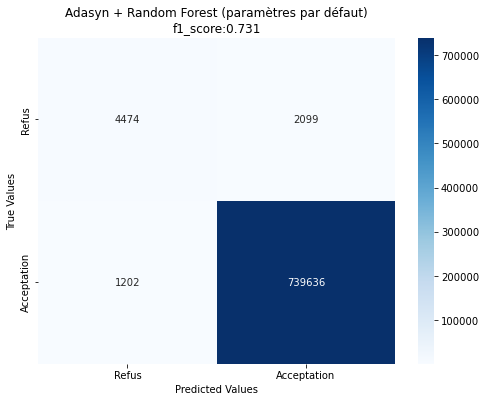

In [131]:
plot_confusion_matrix(yTest,y_pred,"Adasyn + Random Forest (paramètres par défaut)")

In [111]:
Counter(yTest)

Counter({0: 740838, 1: 6573})

Dans notre échantillon de test, nous avons :
- 740 838 transactions normales
- 6573 transactions frauduleuses

TP = 4474 fraudes ont été correctement prédites / 6573  
TN = 739 636 transactions normales correctement prédites / 740 838  
FP = 1202 transactions normales ont été prédites comme frauduleuses  
FN = 2099 transactions frauduleuse ont été prédites comme normales  

F Mesure = 2(4474) /(2(4474) + 1202 + 2099) = 8948/12249 = 0.73

## Random Forest seul 

In [ ]:
Random_Forest_Parameters = {
    'criterion' : ['gini','entropie']
}

In [120]:
%%time
clf.fit(XTrain, yTrain)
y_pred = clf.predict(XTest)

Wall time: 6min 19s


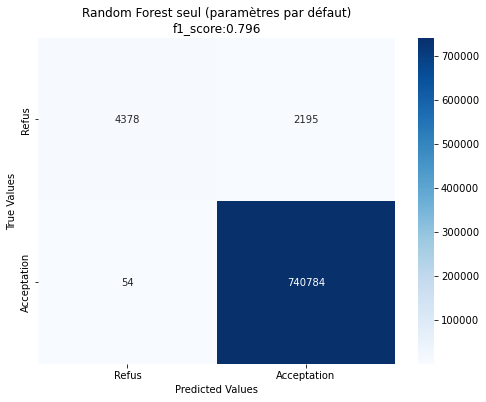

In [128]:
plot_confusion_matrix(yTest,y_pred,"Random Forest seul (paramètres par défaut)")

On obtient un meilleur f1_score sans l'utilisation d'adasyn. 

On constate que l'on a un nombre de faux positifs bien inférieur.

## IsolationForest

In [163]:
clf = IsolationForest(random_state=42,n_jobs=-1,contamination=0.01)

In [164]:
%%time
clf.fit(XTrain)

C:\Users\rodud\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Wall time: 3min 27s


In [172]:
y_pred = clf.predict(XTest)

In [176]:
XTrain

,Montant,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_1,CodeDecision_2,CodeDecision_3
0,-0.420302,-0.581824,-0.552351,-0.521176,1.017656,-0.084590,-0.239505,-0.275801,-0.030212,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.455513,-0.202861,1.0,0.0,0.0
1,-0.420302,-0.581824,-0.552351,-0.521176,1.017656,-0.084590,-0.239505,-0.275801,0.162138,0.818043,-0.043812,4.975724,-1.945875,-0.301229,-0.451325,-0.371994,0.038808,1.0,0.0,0.0
2,-0.022127,-0.581824,-0.552351,-0.521176,1.008573,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.090397,-0.202861,1.0,0.0,0.0
3,-0.057565,1.545332,1.337233,1.088824,-0.272152,-0.084590,-0.239505,-0.275801,1.172099,0.906727,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.122893,-0.202861,0.0,0.0,0.0
4,-0.347310,-0.581824,-0.552351,-0.521176,1.008573,-0.084434,0.637044,-0.273204,0.104780,0.818043,-0.043812,-0.194165,-1.757421,-0.301229,-0.451325,-0.075750,0.702346,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899357,-0.294418,-0.581824,-0.552351,-0.521176,0.658872,-0.081791,-0.410249,-0.216641,0.366548,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.340081,-0.202861,0.0,0.0,0.0
3899358,-0.057988,-0.581824,-0.552351,-0.521176,0.917742,-0.084059,0.707214,-0.273203,0.104780,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.123281,-0.202861,0.0,0.0,0.0
3899359,-0.440507,-0.581824,-0.552351,-0.521176,-0.222195,-0.083916,-1.536879,-0.263031,0.757875,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.474041,-0.202861,0.0,0.0,0.0
3899360,0.370230,-0.581824,-0.552351,-0.521176,-1.362131,-0.074905,-0.343666,-0.213763,-0.030212,0.818043,4.131997,-0.194165,-1.755944,-0.301229,-0.451325,0.580276,0.696732,0.0,0.0,0.0


In [177]:
Counter(y_pred)

Counter({1: 741856, -1: 5555})

In [167]:
# 1 = inlieurs
# -1 = outliers

In [184]:
y_pred = np.where(y_pred==1, 0, y_pred) 
Counter(y_pred)

Counter({0: 741856, -1: 5555})

In [188]:
y_pred = np.where(y_pred == -1, 1, y_pred) 
Counter(y_pred)

Counter({0: 741856, 1: 5555})

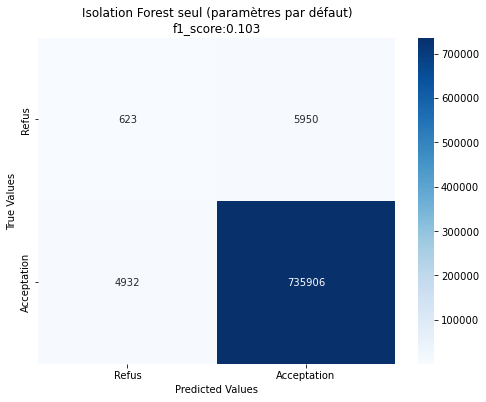

In [189]:
plot_confusion_matrix(yTest,y_pred,"Isolation Forest seul (paramètres par défaut)")

<font color='red'>⚠️BEAUCOUP TROP LONG TROUVER SOLUTION POUR DELAYED⚠️</font>

In [ ]:
#Scaling sinon Warning en sortie
scaler = MinMaxScaler().fit(XTrain)
#fit_Scale = delayed(scaler.fit)(XTrain)
#XTrain_Scale = delayed(fit_Scale.transform)(XTrain)
#XTest_Scale = delayed(fit_Scale.transform)(XTest)
XTrain_Scale = scaler.transform(XTrain)
XTest_Scale = scaler.transform(XTest)

<h4><font color='BLUE'>REGRESSION LOGISTIQUE PAR DEFAULT</font></h4>

In [ ]:
#Regression Logistique
LR = LogisticRegression(max_iter=5000)
fit_LR = delayed(LR.fit)(XTrain_Scale,yTrain)

In [ ]:
#Calcul des prédictions
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

col_0       0     1
row_0              
0      740367   471
1        3668  2905


In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.86      0.44      0.58      6573

    accuracy                           0.99    747411
   macro avg       0.93      0.72      0.79    747411
weighted avg       0.99      0.99      0.99    747411



<h4><font color='BLUE'>ESSAIE METHODE UNDERSAMPLING "RANDOM" + REGRESSION LOGISTIQUE PAR DEFAULT</font></h4>

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

<font color='red'>⚠️TROUVER UNE SOLUTION AU TYPAGE DU XTRAIN_SCALE⚠️</font>

In [ ]:
#Implémentation
#XTrain_Scale = ddf.DataFrame(XTrain_Scale)
#XTrain_Scale = XTrain_Scale.values
#yTrain = yTrain.values
rus = RandomUnderSampler()
Xrus,yrus = rus.fit_resample(XTrain_Scale, yTrain)

In [ ]:
LR = LogisticRegression(max_iter=5000)
fit_LR = delayed(LR.fit)(Xrus,yrus)

In [ ]:
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

col_0       0      1
row_0               
0      701081  39757
1        1271   5302


In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    740838
           1       0.12      0.81      0.21      6573

    accuracy                           0.95    747411
   macro avg       0.56      0.88      0.59    747411
weighted avg       0.99      0.95      0.96    747411



<font color='BLUE'>CONCLUSION : MOINS BON AVEC UNDERSAMPLING RANDOM<br/>
QUESTION : POURQUOI?</font>

<h4><font color='BLUE'>ESSAIE METHODE UNDERSAMPLING "RANDOM" + REGRESSION LOGISTIQUE solver="SAGA"</font></h4>

In [ ]:
LR = LogisticRegression(solver ="saga",max_iter=5000)
fit_LR = delayed(LR.fit)(Xrus,yrus)

In [ ]:
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

col_0       0      1
row_0               
0      701076  39762
1        1271   5302


In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    740838
           1       0.12      0.81      0.21      6573

    accuracy                           0.95    747411
   macro avg       0.56      0.88      0.59    747411
weighted avg       0.99      0.95      0.96    747411



<h4><font color='BLUE'>ESSAIE METHODE UNDERSAMPLING "RANDOM" + REGRESSION LOGISTIQUE solver="SAGA" penalty="l1"</font></h4>

In [ ]:
LR = LogisticRegression(solver ="saga",penalty="l1",max_iter=5000)
fit_LR = delayed(LR.fit)(Xrus,yrus)

In [ ]:
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

col_0       0      1
row_0               
0      701631  39207
1        1286   5287


In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    740838
           1       0.12      0.80      0.21      6573

    accuracy                           0.95    747411
   macro avg       0.56      0.88      0.59    747411
weighted avg       0.99      0.95      0.97    747411



<h4><font color='BLUE'>ESSAIE METHODE UNDERSAMPLING "RANDOM" + REGRESSION LOGISTIQUE solver="SAGA" penalty="elasticnet"</font></h4>

In [ ]:
LR = LogisticRegression(solver ="saga",penalty="elasticnet",max_iter=5000,l1_ratio=0.3)
fit_LR = delayed(LR.fit)(Xrus,yrus)

In [ ]:
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

col_0       0      1
row_0               
0      701252  39586
1        1270   5303


In [ ]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    740838
           1       0.12      0.81      0.21      6573

    accuracy                           0.95    747411
   macro avg       0.56      0.88      0.59    747411
weighted avg       0.99      0.95      0.96    747411



<h4><font color='BLUE'>ESSAIE METHODE UNDERSAMPLING "EditedNearestNeighbours" + REGRESSION LOGISTIQUE PAR DEFAULT</font></h4>

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(XTrain_Scale, yTrain)

In [ ]:
LR = LogisticRegression(max_iter=5000)
fit_LR = delayed(LR.fit)(Xrus,yrus)

In [ ]:
yPred = (delayed(fit_LR.predict)(XTest_Scale))
yPred =yPred.compute()

In [ ]:
print(pd.crosstab(yTest,yPred))

In [ ]:
print(classification_report(yTest,yPred))